In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
import torch
from evasion_guidance.scripts.pycubicspline import *
from evasion_guidance.scripts.aircraft_model import AirCraftModel
from evasion_guidance.scripts.evasion_risk import EvasionRisk
from evasion_guidance.scripts.utils import generate_radar_config, visualiza_radar_config
import itertools
import os
import yaml
import time 
from matplotlib.collections import LineCollection
from evasion_guidance.scripts.bc_train import CVAEModel
from evasion_guidance.scripts.utils import *

%matplotlib widget
matplotlib.rcParams['figure.figsize'] = (10, 10)

### Load checkpoint ###

In [2]:
checkpoints_path = "../checkpoints"
run_name = "bc_cvae_2b84f851"
checkpoint_name = "model.pth"
checkpoint = torch.load(os.path.join(checkpoints_path, run_name, checkpoint_name)) 
with open(os.path.join(checkpoints_path, run_name, 'config.yaml'),"r") as file_object:
        config = yaml.load(file_object,Loader=yaml.SafeLoader)

device=torch.device('cuda')
model = CVAEModel(config['model']['hidden_dim'], config['model']['cvae_latent_dim']).to(device)
model.device = device
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Creating model


/tmp/ipykernel_310854/3974196847.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoints_path, run_name, checkpoint_name))


CVAEModel(
  (cnn): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=5184, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (model): CVAE(
    (encoder): Encoder(
      (linear1): Linear(in_features=278, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (linear3): Linear(in_features=64, out_features=64, bias=True)
      (linear_mu): Linear(in_features=64, out_features=16, bias=True)
      (linear_logvar): Linear(in_features=64, out_features=16, bias=True)
    )
    (decoder): Decoder(
      (linear1): Linear(in_features=274, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features

### Load data parameters ###

In [3]:
with open("../params/rrt_data_collection.yaml","r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)
with open("../params/mcmc_refine.yaml","r") as file_object:
    mcmc_config = yaml.load(file_object,Loader=yaml.SafeLoader)

map_range = config['env']['map_range']
radar_radius = config['env']['radar_radius']
min_num_radar = config['env']['min_num_radar']
max_num_radar = config['env']['max_num_radar']
V = config['planner']['V']
L1 = config['planner']['L1']
planning_delta_t = config['planner']['delta_t']
num_boundary_sample = config['planner']['serach_center_parameters']['num_boundary_sample']
bloat_radius = config['planner']['serach_center_parameters']['bloat_radius']
max_iter = config['planner']['max_iter']
random_sampling = config['data_collection']['random_sample']
search_radius= config['planner']['search_radius']
risk_interval= config['planner']['risk_buffer_length']
connect_circle_dist=config['planner']['connect_circle_dist']
min_dist_to_risk_radius_ratio=config['planner']['min_dist_to_risk_radius_ratio']
min_search_center_num=config['planner']['min_search_center_num']
max_collection_loop_num= config['data_collection']['collection_loop_num']

### Load parameters used to train the model ###

In [4]:
with open("../params/bc_data.yaml","r") as file_object:
    bc_data_config = yaml.load(file_object,Loader=yaml.SafeLoader)

data_num = bc_data_config['load_data_num']
img_size = bc_data_config['env']['img_size']
radar_radius = bc_data_config['env']['radar_radius']
aircraft_detection_range = bc_data_config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
observation_img_size = [1, img_size, img_size]


In [5]:
data_idx = 0
rrt_data_path = config['data_collection']['output_path']
data = np.load(rrt_data_path + f'episode_{data_idx}.npy',allow_pickle='TRUE').item()
radar_locs = data['radar_locations']
path_rrt = data['state_history']
inputs = data['input_history']
risk_radius = config['env']['radar_radius']
risk_buffer_length = config['planner']['risk_buffer_length']
risk_evaluator = EvasionRisk(radar_locs, risk_buffer_length, risk_radius)
V = config['planner']['V']
L1 = config['planner']['L1']
_, risk_rrt = risk_evaluator.evalute_trajectory_risk(path_rrt, inputs, True)

mcmc_data_path = mcmc_config['output_path']
knot_points = np.load(mcmc_data_path + f"episode_{data_idx}.npy")
x, y, yaw, k, travel, u = calc_2d_spline_interpolation(knot_points[:, 0], knot_points[:, 1], v=V, num=100)
_, risks = risk_evaluator.evalute_trajectory_risk(np.asarray([[x[i], y[i], yaw[i]] for i in range(len(x))]), u, True)
path_expert = np.asarray([[x[i], y[i], yaw[i]] for i in range(len(x))])

### Use the student policy to produce path. Note that each run will result in a different path since the student is not a deterministic policy. ###

Goal:  [413.92176659  60.40312843]
Risk rrt:  0.17342017614899954
Risk expert:  0.06521488410731022
Risk student:  0.15027998814873134


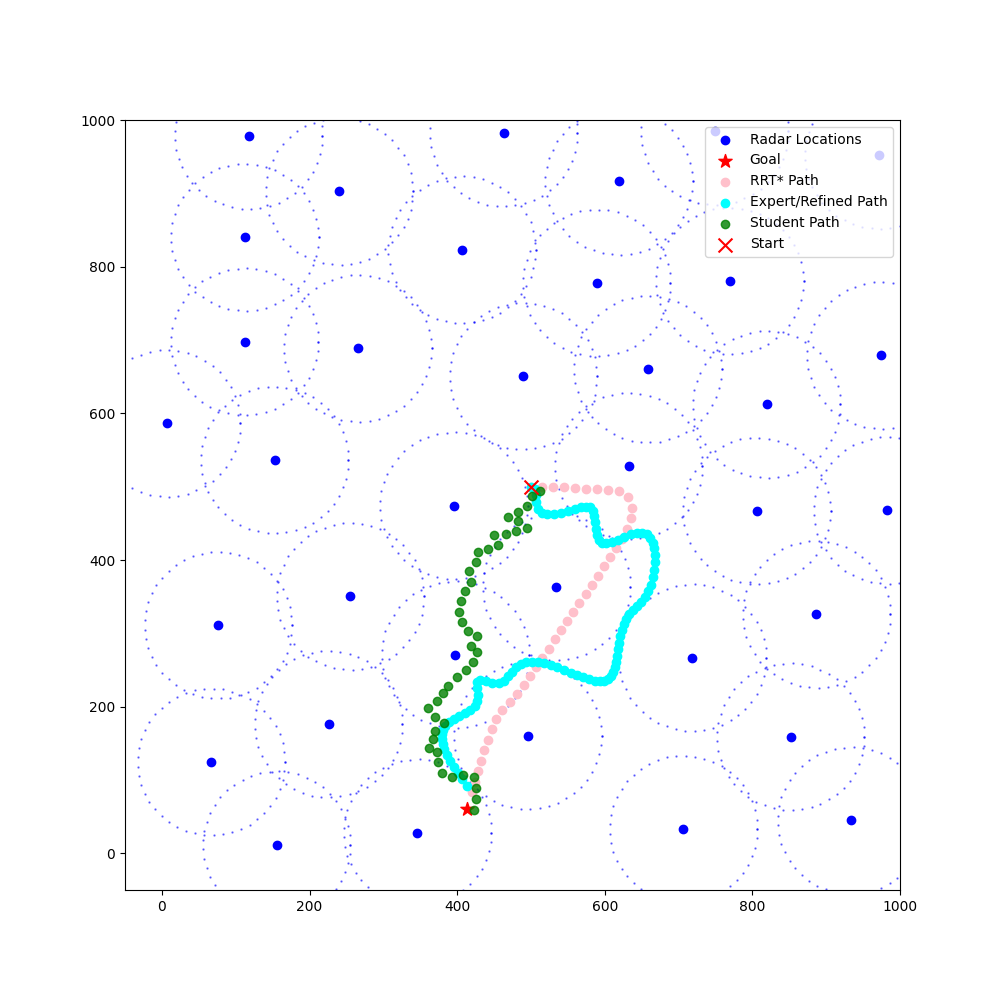

In [6]:
goal = data['goal_location']
print("Goal: ", goal)
x_cur = data['start_state']
paths = []
planned_paths = []
iter_num = 0
inference_time = []
while math.hypot(x_cur[0] - goal[0], x_cur[1] - goal[1]) > 10.0:
    iter_num += 1
    ### Generate heat map ###
    heat_map = get_radar_heat_map(x_cur, radar_locs, img_size, 
                                aircraft_detection_range, grid_size) / 255.0
    heat_map_gpu = torch.from_numpy(heat_map).unsqueeze(dim=0).to(device).float()

    ### Generate goal direction ###
    goal_dir = goal - x_cur[:2]
    goal_dir /= np.linalg.norm(goal_dir)
    goal_dir_gpu = torch.from_numpy(goal_dir).unsqueeze(dim=0).to(device).float()
    
    time_begin = time.time()
    with torch.no_grad():
        planned_path = model.act(heat_map_gpu, goal_dir_gpu).view(10, 2)
    time_end = time.time()

    inference_time.append(time_end - time_begin)

    ### Note that during training the planned paths were divided by a large constant, here we scale it back
    planned_path = 150.0*planned_path.squeeze().cpu().numpy()
    planned_path_world_frame = []
    planned_path_world_frame.extend(list(planned_path + x_cur[:2]))
    planned_path_world_frame = np.asarray(planned_path_world_frame)
    planned_paths.append(planned_path_world_frame)

    ### Perform interpolation
    x, y, yaw, _, _, _ = calc_2d_spline_interpolation(planned_path_world_frame[:, 0], planned_path_world_frame[:, 1], v=V, num=20)

    ### Only take the next one point
    idx = 0
    x_cur = np.asarray([planned_path_world_frame[idx][0], planned_path_world_frame[idx][1], yaw[idx]])
    paths.append(x_cur)

paths = np.asarray(paths)
x, y, yaw, k, travel, u = calc_2d_spline_interpolation(paths[:, 0], paths[:, 1], v=V, num=100)
_, risks_after = risk_evaluator.evalute_trajectory_risk(np.asarray([[x[i], y[i], yaw[i]] for i in range(len(x))]), u, True)
print("Risk rrt: ", sum(risk_rrt) / (len(risk_rrt)))
print("Risk expert: ", sum(risks) / (len(risks)))
print("Risk student: ", sum(risks_after) / (len(risks_after)))
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radius=config['env']['radar_radius'], xlim=[-50, config['env']['map_range']], ylim=[-50, config['env']['map_range']])
ax.scatter(goal[0], goal[1], s=100, c='r', label='Goal', marker='*')
ax.scatter(path_rrt[:, 0], path_rrt[:, 1], label="RRT* Path", c='pink')
ax.scatter(path_expert[:, 0], path_expert[:, 1], label="Expert/Refined Path", c='cyan')
ax.scatter(paths[:, 0], paths[:, 1], label="Student Path", c='g', alpha=0.8)
ax.scatter(500.0, 500.0, s=100, c='r', label='Start', marker='x')
ax.legend()
plt.show()